## load thư viện

In [19]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib.pyplot as plt

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import cohen_kappa_score

import tensorflow
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import optimizers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle
import seaborn as sns

from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords

import keras
import io
import requests
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from underthesea import word_tokenize

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
K._get_available_gpus()
import codecs

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2072091758969520490
xla_global_id: -1
]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Hàm

**CHUẨN HÓA TEXT THÀNH VECTOR**

* Tạo stopword việt Nam

In [20]:
def create_stopwordlist():
    f = codecs.open('vietnamese-stopwords.txt', encoding='utf-8')
    data = []
    null_data = []
    for i, line in enumerate(f):
        line = repr(line)
        line = line[1:len(line)-3]
        data.append(line)
    return data

* Tokenize

In [21]:
import string
stopword_vn = create_stopwordlist()
def tokenize(text):
    text =  text.translate(str.maketrans('', '', string.punctuation))
    return [word for word in word_tokenize(text.lower()) if word not in stopword_vn]

* vectorizer

In [22]:
def choose_vectorizer(option, name='tf_idf'):
    if option == 'generate':
        if name == 'tf_idf':
            vectorizer = TfidfVectorizer(tokenizer = tokenize,ngram_range=(1,4), min_df=5, max_df= 0.8, max_features=5000, sublinear_tf=True)
        else:
            vectorizer = CountVectorizer(tokenizer = tokenize, ngram_range=(1,4), max_df=0.8, min_df=5, max_features =5000, sublinear_tf=True)
    elif option == 'load':
        if name == 'tf_idf':
            vectorizer = TfidfVectorizer(vocabulary = pickle.load(open('vocabulary_3.pkl', 'rb')), ngram_range=(1,3), min_df=5, max_df= 0.8, max_features=15000, sublinear_tf=True)
        else:
            vectorizer = CountVectorizer(vocabulary = pickle.load(open('vocabulary_3.pkl', 'rb')), ngram_range=(1,3), max_df=0.8, min_df=5, max_features = 15000, sublinear_tf=True)
    return vectorizer

**XỬ LÍ TEXT CƠ BẢN**

* Xóa các kí tự đặt biệt

In [23]:
import re
import string
def word_drop(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

* sửa đổi các từ viết tắt cơ bản

In [24]:
def replace_acronym(text):
    text=" "+text+" "
    for i in [' o k ',' oki ',' oke ',' o ke ',' okay ',' okie ',' okey ',' okela ',' okila ',' okla ']:
        text=text.replace(i,' ok ')
        
    for i in [' k ',' kh ',' ko ',' khg ',' kg ',' khong ',' khôg ']:
        text=text.replace(i,' không ')
        
    for i in [' ktra ',' check ',' test ']:
        text=text.replace(i,' kiểm tra ')
        
    for i in [' đc ',' dc ',' đk ',' dk ',' đuoc ']:
        text=text.replace(i,' được ')
    
    for i in [' v ',' z ',' vây ']:
        text=text.replace(i,' vậy ')
        
    for i in[' cu ng ',' cx ']:
        text=text.replace(i,' cũng ')
    
    for i in[' vs ',' vơ i ',' vo i ']:
        text=text.replace(i,' với ')
        
    for i in[' mn ',' mng ',' mọi ng ']:
        text=text.replace(i,' mọi người ')
        
    for i in[' sp ',' sa n phâ m ',' san pham ']:
        text=text.replace(i,' sản phẩm ')
    
    for i in[' mh ',' mi nh ',' minh ',' mk ']:
        text=text.replace(i,' mình ')
     
    for i in[' tiki ',' shoppe ',' sope ',' shope ',' ti ki ',' soppe ']:
        text=text.replace(i,' ')
        
    for i in[' wa ',' qá ']:
        text=text.replace(i,' quá ')   
        
    for i in[' hàn ',' hàg ']:
        text=text.replace(i,' hàng ') 
    
    for i in[' tl ',' rep ']:
        text=text.replace(i,' trả lời ')
    
    for i in[' nhma ',' nhưg ',' nma ',' nhg ']:
        text=text.replace(i,' nhưng mà ') 
        
    text=text.replace(' j ',' gì ')
    text=text.replace(' sd ',' sử dụng ')
    text=text.replace(' trc ',' trước ')
    text=text.replace(' vn ',' việt nam ')
    text=text.replace(' sz ',' size ')
    text=text.replace(' sp ',' sản phẩm ')
    text=text.replace(' r ',' rồi ')
    text=text.replace(' rùi ',' rồi ')
    text=text.replace(' s ',' sao ')
    text=text.replace(' ms ',' mới ')
    text=text.replace(' nv ',' như vậy ')
    text=text.replace(' ntn ',' như thế nào ')
    text=text.replace(' đ ep ',' đẹp ').replace(' đep ',' đẹp ')
    text=text.replace(' thực sự ',' thật sự ')
    text=text.replace(' đu ng ',' đúng ')
    text=text.replace(' nao ',' nào ')
    text=text.replace(' sài ',' xài ')
    text=text.replace(' sơ xài ',' sơ sài ')
    text=text.replace(' ghn ',' giao hàng ')
    text=text.replace(' siu ',' siêu ')
    text=text.replace(' nge ',' nghe ')
    text=text.replace(' nch ',' nói chuyện ')
    text=text.replace(' ns ',' nói ')
    text=text.replace(' rì viu ',' review ')
    text=text.replace(' tot ',' tốt ')
    text=text.replace(' rát ',' rất ').replace(' rat ',' rất ')
    return text

* xóa các kí tự bị lặp

In [25]:
import unidecode
def re_accent(text):
    return unidecode.unidecode(text)
def loai_cac_ki_tu_lap(a):
    for i in range(len(a)-1):
        while (i+1<=len(a)-1):
            if re_accent(a[i])==re_accent(a[i+1]):
                a=a.replace(a[i]+a[i+1],a[i])
            else:
                break
    return a

* xử lí text

In [26]:
def xu_li_text(text):
    text=word_drop(text)
    text=loai_cac_ki_tu_lap(text)
    text=replace_acronym(text)
    return text

**CÁC ĐỘ ĐO**

* recall
* precision
* f1

In [27]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## load và khám phá data 

In [28]:
# data = pd.read_csv('../input/kpdl-data/train_v1.csv')
data = pd.read_csv('NPL_data_DS310.N11.csv')
data=data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
data.info()
print(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14309 entries, 0 to 14308
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  14309 non-null  object
 1   rating    14309 non-null  object
dtypes: object(2)
memory usage: 223.7+ KB
                                            comments           rating
0                 nhanh  sách đẹp  y chang quảng cáo  Cực kì hài lòng
1  nồi to  dùng cho gia đình có   thành viên là ổ...  Cực kì hài lòng
2  gói hàng khá chắc chắn k bị gãy góc  nhìn phần...  Cực kì hài lòng
3                giao hàng rất nhanh và đóng gói đẹp  Cực kì hài lòng
4                                                tốt  Cực kì hài lòng
5  xài ok  hàng quốc dân rồi  xài trong  phòng th...  Cực kì hài lòng
6  hic  bình giữ nhiệt tốt quá  từ  đến  mà nước ...  Cực kì hài lòng
7  wifi đã phát ổn định hơn rấy nhiều luôn  tiki ...  Cực kì hài lòng
8  giao hàng rất nhanh ạ  màu gold siêu đẹp  sang...  Cực kì hài lòn

In [29]:
data.isna().sum()

comments    0
rating      0
dtype: int64

<AxesSubplot: >

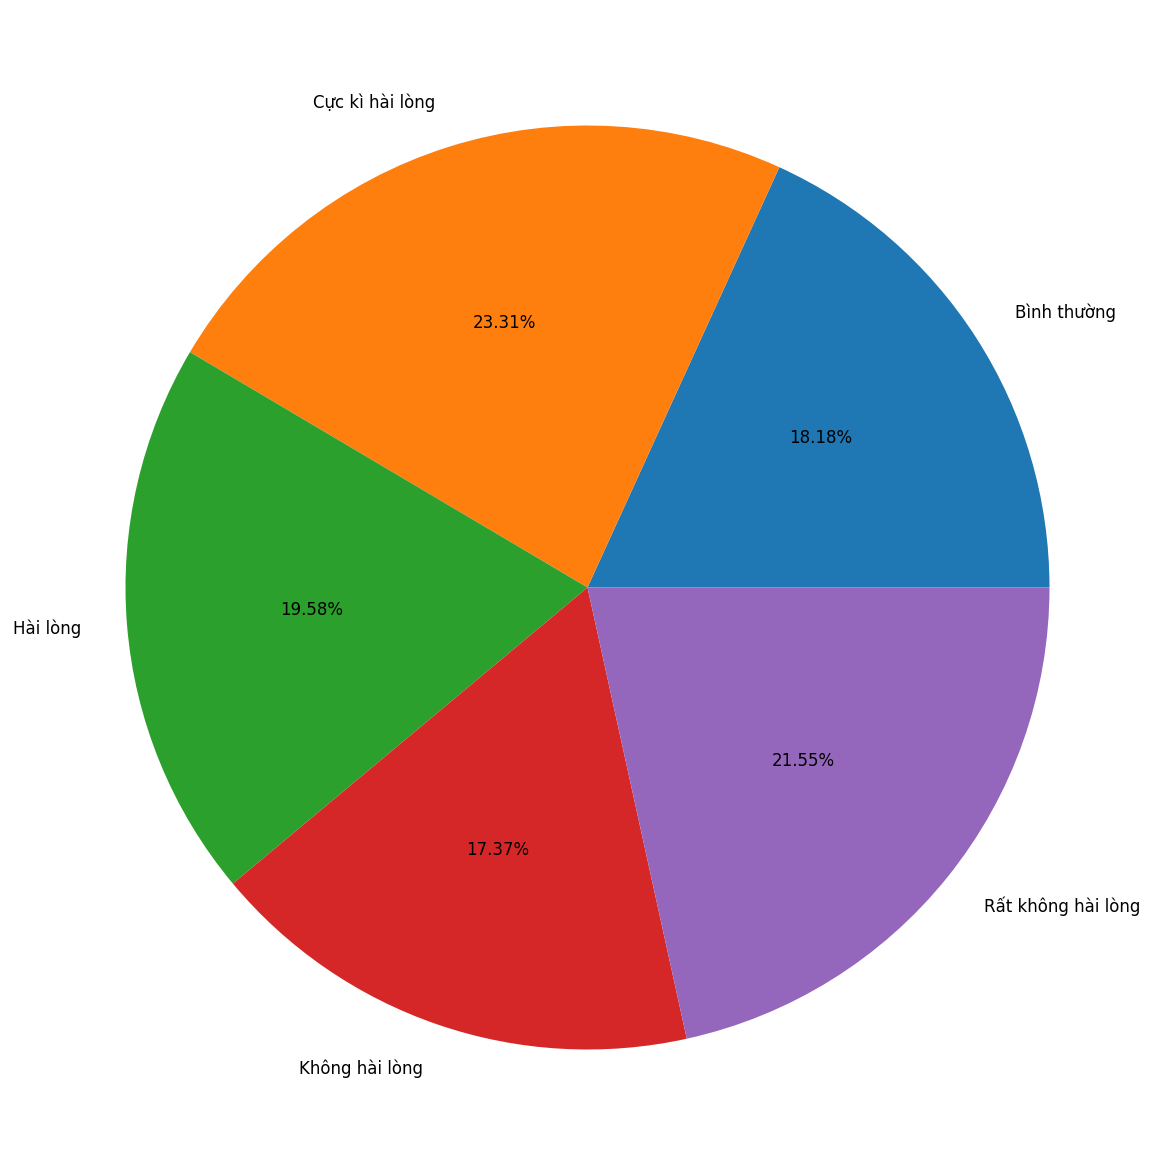

In [160]:
data_label = data['rating']
data_label = pd.DataFrame(data_label, columns=['rating']).groupby('rating').size()
data_label.plot.pie(figsize=(15, 15), autopct="%.2f%%", fontsize=12)

## Xử lí data 

In [161]:
data['comments']=data['comments'].apply(xu_li_text)
data.head(30)

,Unnamed: 0.1,Unnamed: 0,comments,rating
0,0,0,nhanh sách đẹp y chang quảng cáo,Cực kì hài lòng
1,1,1,nồi to dùng cho gia đình có thành viên là ổn ...,Cực kì hài lòng
2,2,2,gói hàng khá chắc chắn không bị gãy góc nhìn ...,Cực kì hài lòng
3,3,3,giao hàng rất nhanh và đóng gói đẹp,Cực kì hài lòng
4,4,4,tốt,Cực kì hài lòng
5,5,5,xài ok hàng quốc dân rồi xài trong phòng thì ...,Cực kì hài lòng
6,6,6,hic bình giữ nhiệt tốt quá từ đến mà nước vẫn...,Cực kì hài lòng
7,7,7,wifi đã phát ổn định hơn rấy nhiều luôn đóng ...,Cực kì hài lòng
8,8,8,giao hàng rất nhanh ạ màu gold siêu đẹp sang ...,Cực kì hài lòng
9,9,9,lần này đóng gói cẩn thận có dán nhãn hàng dễ...,Cực kì hài lòng


In [163]:
c=data['comments'].values
for indx, dt in enumerate(c):
    print(indx)
    print(dt)

0
 nhanh sách đẹp y chang quảng cáo 
1
 nồi to dùng cho gia đình có thành viên là ổn mua được lúc săn sale nên rất hời nhưng có điều ship lâu quá  
2
 gói hàng khá chắc chắn không bị gãy góc nhìn phần keo sách có vẻ hơi lỏng lẻo 
3
 giao hàng rất nhanh và đóng gói đẹp 
4
 tốt 
5
 xài ok hàng quốc dân rồi xài trong phòng thì ok nhà rộng qua phòng khác thì wifi yếu hẳn 
6
 hic bình giữ nhiệt tốt quá từ đến mà nước vẫn nóng quá trời bỏng cả lưỡi 
7
 wifi đã phát ổn định hơn rấy nhiều luôn đóng gói cẩn thận và giao hàng nhanh mình rất hài lòng 
8
 giao hàng rất nhanh ạ màu gold siêu đẹp sang trọng build khá chắc chắn hệ điều hành mac hơi khác windows nên phải từ từ làm quen nói chung ổn hàng sa việt nam nên yên tâm hơn xíu  
9
 lần này đóng gói cẩn thận có dán nhãn hàng dễ vỡ bình không móp méo màu trắng có ánh nhũ nhìn xinh bình nhẹ nắp bình đơn giản dễ vệ sinh cổ rộng dễ cho đá vào nên nhìn nhỏ gọn thích hợp mang đi học hoặc đi làm  
10
 sản phẩm giao nhanh nhưng mà đóng gói rất hời hợt 

## chia tập data 

In [164]:
category = data['rating'].unique()
category_to_id = {cate: idx for idx, cate in enumerate(category)}
id_to_category = {idx: cate for idx, cate in enumerate(category)}
print(category_to_id)
print(id_to_category)

{'Cực kì hài lòng': 0, 'Hài lòng': 1, 'Bình thường': 2, 'Không hài lòng': 3, 'Rất không hài lòng': 4}
{0: 'Cực kì hài lòng', 1: 'Hài lòng', 2: 'Bình thường', 3: 'Không hài lòng', 4: 'Rất không hài lòng'}


In [165]:
X_train, X_test, y_train, y_test = train_test_split(data['comments'], data['rating'], test_size = .15, shuffle = True, stratify=data['rating'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, shuffle = True, stratify=y_train)

In [166]:
X_train_df = pd.DataFrame(X_train, columns=['comments'])
X_valid_df = pd.DataFrame(X_valid, columns=['comments'])
X_test_df = pd.DataFrame(X_test, columns=['comments'])
print(X_train_df.head(10))
print(X_valid_df.head(10))
print(X_test_df.head(10))

                                                comments
8962                                không thể mặc được  
10903                                sản phẩm tuyệt vời 
12568                                             thân  
11552                             tất đẹp thật sự đó ạ  
9271    cho mình đổi mình đặt xl mà giao sao sao mặt ...
7164                                       hộp bị rách  
140     to hơn mình nghĩ chiên khá ngon vàng đều mặt ...
4382             tiền nào của nấy vậy mà hỏng đặt tiếp  
9438      mới nhận sản phẩm không sử dụng được báo lỗi  
11145   chắc đây sẽ là lần đầu và cũng là lần cuối cù...
                                                comments
13799   thái đô kém thời gian giao hàng rất chậm shop...
4357                    tín hiệu yếu không như mong đợi 
10684            mình đặt size xl mà lại giao size sao  
13064              cho mình đổi mình đặt xl mà giao sao 
7795           và mùi cực kì nồng không thơm tí nào cả  
6560                 m mặc sao 

## vector hóa data

In [167]:
%%time
options = ['generate', 'load']
# 0 to generate, 1 to load (choose wisely, your life depends on it!)
option = options[0] 
vectorizer = choose_vectorizer(option)

X_train = vectorizer.fit_transform(X_train).toarray()
X_valid = vectorizer.transform(X_valid).toarray()
X_test = vectorizer.transform(X_test).toarray()
    
if option == 'generate':
    pickle.dump(vectorizer.vocabulary_, open('vocabulary_3.pkl', 'wb'))

CPU times: total: 14.5 s
Wall time: 14.5 s


In [168]:
print(X_train.shape, X_valid.shape, X_test.shape)

(9729, 5000) (2433, 5000) (2147, 5000)


In [170]:
print(vectorizer.get_feature_names())

['a', 'a o', 'active', 'ad', 'ah', 'ai', 'ai mua', 'ak', 'an toàn', 'an tâm', 'and', 'anh', 'anh shiper', 'ao', 'ap', 'aple', 'b', 'ba', 'balo', 'ban', 'ban đầu', 'bao', 'bao bì', 'bao bọc', 'bao giờ', 'bao giờ mua', 'bao nhiêu', 'bas', 'bh', 'bi', 'biet', 'biết', 'biết chất lượng', 'biết có', 'biết có bền', 'biết có bền không', 'biết có bị', 'biết dùng', 'biết là', 'biết là do', 'biết phải', 'biết sao', 'biết thế nào', 'biết được', 'black', 'bluetoth', 'bo', 'bokcare', 'bokmark', 'bong', 'bong bóng', 'box', 'bt', 'bung', 'bung chỉ', 'buồn', 'bài', 'bàn', 'bàn chải', 'bàn chải không', 'bàn chải điện', 'bàn rồi', 'bàn ủi', 'bám', 'bán', 'bán hàng', 'bán không', 'bánh xe', 'báo', 'báo là', 'bát', 'bây giờ', 'bé', 'bé hơn', 'bé như', 'bé zeze', 'bên', 'bên bán', 'bên cạnh', 'bên không', 'bên kia', 'bên ngoài', 'bên phải', 'bên phải thì', 'bên shop', 'bên tai', 'bên tai nghe', 'bên trong', 'bên trong không', 'bên trái', 'bên vận chuyển', 'bìa', 'bìa sách', 'bìa sách bị', 'bìa sách đẹp', 'b

In [216]:
y_ = y_train.map(category_to_id).values
y_train = np.zeros((len(y_), y_.max()+1))
y_train[np.arange(len(y_)), y_] = 1
# y_train = y_

y_ = y_test.map(category_to_id).values
y_test = np.zeros((len(y_), y_.max()+1))
y_test[np.arange(len(y_)), y_] = 1
# y_test = y_

y_ = y_valid.map(category_to_id).values
y_valid = np.zeros((len(y_), y_.max()+1))
y_valid[np.arange(len(y_)), y_] = 1
# y_valid = y_

AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [217]:
print(y_train.sum(1))
print(y_valid.sum(1))
print(y_test.sum(1))
print(y_train.shape, y_valid.shape, y_test.shape)

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
(9729, 5) (2433, 5) (2147, 5)


## Xây dựng model

In [218]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
DROPOUT = 0.3
ACTIVATION = "relu"

model = Sequential([    
    Dense(1000, activation=ACTIVATION, input_dim=X_train.shape[1]),
    Dropout(DROPOUT),
    Dense(500, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(300, activation=ACTIVATION),
    Dropout(DROPOUT),
    #Dense(200, activation=ACTIVATION),
    #Dropout(DROPOUT),
    #Dense(100, activation=ACTIVATION),
    #Dropout(DROPOUT),
    #Dense(50, activation=ACTIVATION),
    #Dropout(DROPOUT),
    Dense(5, activation='softmax'),
])

In [219]:
model.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['acc', f1_m,precision_m, recall_m])

model.summary()
es = EarlyStopping(monitor='val_f1_m', mode='max', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', factor=0.2, patience=8, min_lr=1e7)
checkpoint = ModelCheckpoint('best_full.h5', monitor='val_f1_m', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1000)              5001000   
                                                                 
 dropout_10 (Dropout)        (None, 1000)              0         
                                                                 
 dense_13 (Dense)            (None, 500)               500500    
                                                                 
 dropout_11 (Dropout)        (None, 500)               0         
                                                                 
 dense_14 (Dense)            (None, 300)               150300    
                                                                 
 dropout_12 (Dropout)        (None, 300)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                

## Huấn luyện model

In [220]:
EPOCHS = 25
BATCHSIZE = 4

In [221]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCHSIZE, validation_data=(X_valid, y_valid), callbacks=[es, reduce_lr, checkpoint])

Epoch 1/25
2433/2433 [==============================] - 37s 15ms/step - loss: 1.2045 - acc: 0.4954 - f1_m: 0.3577 - precision_m: 0.5701 - recall_m: 0.2781 - val_loss: 1.0839 - val_acc: 0.5590 - val_f1_m: 0.4676 - val_precision_m: 0.6524 - val_recall_m: 0.3855 - lr: 0.0010
Epoch 2/25
2433/2433 [==============================] - 38s 16ms/step - loss: 0.8544 - acc: 0.6673 - f1_m: 0.6167 - precision_m: 0.7662 - recall_m: 0.5398 - val_loss: 1.0386 - val_acc: 0.5988 - val_f1_m: 0.5483 - val_precision_m: 0.7029 - val_recall_m: 0.4737 - lr: 0.0010
Epoch 3/25
2433/2433 [==============================] - 36s 15ms/step - loss: 0.5377 - acc: 0.8064 - f1_m: 0.7909 - precision_m: 0.8556 - recall_m: 0.7492 - val_loss: 1.2515 - val_acc: 0.6087 - val_f1_m: 0.5968 - val_precision_m: 0.6549 - val_recall_m: 0.5595 - lr: 0.0010
Epoch 4/25
2433/2433 [==============================] - 37s 15ms/step - loss: 0.3129 - acc: 0.8920 - f1_m: 0.8893 - precision_m: 0.9192 - recall_m: 0.8685 - val_loss: 1.6126 - val_a

In [ ]:
x = np.arange(EPOCHS)
history = model.history.history

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

model.save('my_model_NPL.h5')


## Kiểm tra model

In [ ]:
predict_train = model.predict(X_train)
predict_valid = model.predict(X_valid)
predict_test = model.predict(X_test)
print(predict_train.shape, predict_valid.shape, predict_test.shape)

In [ ]:
predict_train_label = predict_train.argmax(-1)
predict_valid_label = predict_valid.argmax(-1)
predict_test_label = predict_test.argmax(-1)

In [226]:
predict_train_label = [id_to_category[predict_train_label[idx]] for idx in range(len(predict_train))]
predict_valid_label = [id_to_category[predict_valid_label[idx]] for idx in range(len(predict_valid))]
predict_test_label = [id_to_category[predict_test_label[idx]] for idx in range(len(predict_test))]

In [227]:
y_train_true = y_train.argmax(-1)
y_valid_true = y_valid.argmax(-1)
y_test_true = y_test.argmax(-1)

In [228]:
y_train_label = [id_to_category[y_train_true[idx]] for idx in range(len(y_train_true))]
y_valid_label = [id_to_category[y_valid_true[idx]] for idx in range(len(y_valid_true))]
y_test_label = [id_to_category[y_test_true[idx]] for idx in range(len(y_test_true))]

In [229]:
train_concat = np.concatenate((np.array(X_train_df['comments'].values).reshape(-1, 1), np.array(y_train_label).reshape(-1, 1), np.array(predict_train_label).reshape(-1, 1)), axis=-1)
valid_concat = np.concatenate((np.array(X_valid_df['comments'].values).reshape(-1, 1), np.array(y_valid_label).reshape(-1, 1), np.array(predict_valid_label).reshape(-1, 1)), axis=-1)
test_concat = np.concatenate((np.array(X_test_df['comments'].values).reshape(-1, 1), np.array(y_test_label).reshape(-1, 1), np.array(predict_test_label).reshape(-1, 1)), axis=-1)

In [230]:
train_concat_predict_df = pd.DataFrame(train_concat, columns=['comment', 'True_Label', 'Predict'])
valid_concat_predict_df = pd.DataFrame(valid_concat, columns=['comment', 'True_Label', 'Predict'])
test_concat_predict_df = pd.DataFrame(test_concat, columns=['comment', 'True_Label', 'Predict'])

In [231]:
a=train_concat_predict_df
a.head(40)

,comment,True_Label,Predict
0,không thể mặc được,Rất không hài lòng,Rất không hài lòng
1,sản phẩm tuyệt vời,Hài lòng,Hài lòng
2,thân,Bình thường,Bình thường
3,tất đẹp thật sự đó ạ,Hài lòng,Hài lòng
4,cho mình đổi mình đặt xl mà giao sao sao mặt ...,Rất không hài lòng,Rất không hài lòng
5,hộp bị rách,Không hài lòng,Không hài lòng
6,to hơn mình nghĩ chiên khá ngon vàng đều mặt ...,Cực kì hài lòng,Cực kì hài lòng
7,tiền nào của nấy vậy mà hỏng đặt tiếp,Bình thường,Bình thường
8,mới nhận sản phẩm không sử dụng được báo lỗi,Rất không hài lòng,Rất không hài lòng
9,chắc đây sẽ là lần đầu và cũng là lần cuối cù...,Hài lòng,Hài lòng


In [233]:
c=test_concat_predict_df
c.tail(40)


                                                comment       True_Label  \
295                              hài lòng với sản phẩm   Cực kì hài lòng   
458        hơi khó xài lúc thì bắt được sóng lúc không   Cực kì hài lòng   
538    đã nhận sản phẩm nhưng chưa khởi động máy chỉ...  Cực kì hài lòng   
548                                      sản phẩm tô t   Cực kì hài lòng   
943    mặc rất thoải mái sẽ theo dõi shop và mua hàn...  Cực kì hài lòng   
1275                                     giá cả hợp lý   Cực kì hài lòng   
1515                                          sạc nóng   Cực kì hài lòng   
1523   m dùng promax phút lên được khoảng từ trở lên...  Cực kì hài lòng   
1944   luôn tin tưởng mua hàng trên bữa mình mua về ...  Cực kì hài lòng   
2063                                             hết ý   Cực kì hài lòng   

                 Predict  
295   Rất không hài lòng  
458   Rất không hài lòng  
538   Rất không hài lòng  
548   Rất không hài lòng  
943   Rất không hài lòng  
1

In [234]:
train_concat_predict_df.to_csv('train_concat_predict_df.csv', index=False)
valid_concat_predict_df.to_csv('valid_concat_predict_df.csv', index=False)
test_concat_predict_df.to_csv('test_concat_predict_df.csv', index=False)

In [235]:
predict_test

array([[1.2283806e-01, 4.0923193e-01, 4.3859947e-01, 2.3950258e-02,
        5.3802454e-03],
       [2.3063086e-10, 5.0061588e-10, 8.6377150e-10, 4.0848342e-09,
        1.0000000e+00],
       [3.3531913e-11, 9.5839214e-06, 4.6454181e-04, 9.9950325e-01,
        2.2596172e-05],
       ...,
       [7.0992947e-01, 2.8993365e-01, 1.3535777e-04, 5.1082552e-08,
        1.5101588e-06],
       [1.0000000e+00, 9.5609698e-10, 1.0008136e-21, 8.9035439e-33,
        1.3483619e-20],
       [4.1591395e-03, 2.0853316e-02, 6.0551268e-01, 8.7131804e-05,
        3.6938775e-01]], dtype=float32)

**Ma trận nhầm lẫn**

Text(0.5, 57.7222222222222, 'Predicted')

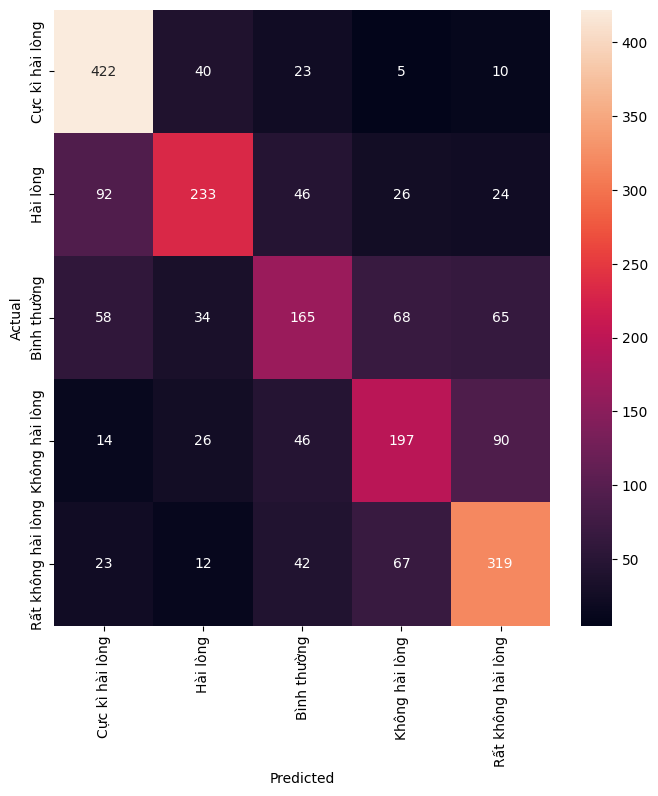

In [236]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(8, 8))
conf_mat = confusion_matrix(y_test_true, predict_test.argmax(-1))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=id_to_category.values(), yticklabels=id_to_category.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [237]:
predict_test = predict_test.argmax(-1)

In [238]:
from sklearn.metrics import f1_score
score = f1_score(y_test_true, predict_test, average='weighted')

In [239]:
score

0.6154130491133311

In [240]:
model.evaluate(X_test,y_test)

68/68 [==============================] - 0s 4ms/step - loss: 2.8420 - acc: 0.6223 - f1_m: 0.6135 - precision_m: 0.6479 - recall_m: 0.5835


[2.8419888019561768,
 0.6222636103630066,
 0.6134790182113647,
 0.6478944420814514,
 0.5834864974021912]

## Kiểm tra với dữ liệu thực tế

In [31]:
def preprocess_raw_input(raw_input):
    raw_input=[raw_input]
    options = ['generate', 'load']
    # 0 to generate, 1 to load (choose wisely, your life depends on it!)
    option = options[1] 
    vectorizer = choose_vectorizer(option)
    input_text_pre = vectorizer.fit_transform(raw_input).toarray()

    return input_text_pre

    

In [32]:
def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output. argmax()
    conf = float (output.max())
    label_dict = {'Cực kì hài lòng': 0, 'Hài lòng': 1, 'Bình thường': 2, 'Không hài lòng': 3, 'Rất không hài lòng': 4}
    label = list(label_dict.keys())
    return label[int(result)], conf


In [33]:
def prediction(raw_input, model):
    input_model = preprocess_raw_input(raw_input)
    result,conf = inference_model(input_model, model)
    return result, conf

In [ ]:
my_model=keras.models.load_model('my_model_NPL.h5', compile=False)
while(True):
    text=input('nhập câu bình luân vào:\n')
    text=xu_li_text(text)
    print('text_pre:',text)
    if text==' end ':
        break
    else:
        print(prediction(text, my_model))


nhập câu bình luân vào:
dep qua nhin rat rat xinhhh
text_pre:  dep qua nhin rất rat xinh 
('Cực kì hài lòng', 0.7198653817176819)
